In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 

path = "/content/data"
os.mkdir(path) 


FileExistsError: ignored

In [ ]:
import shutil

shutil.copy("/content/drive/MyDrive/dataset/annotation.tar","/content/data/annotation.tar")
shutil.copy("/content/drive/MyDrive/dataset/images.tar","/content/data/images.tar")
shutil.copy("/content/drive/MyDrive/dataset/lists.tar", "/content/data/lists.tar")

shutil.unpack_archive("/content/drive/MyDrive/dataset/annotation.tar","/content/data")
shutil.unpack_archive("/content/drive/MyDrive/dataset/images.tar","/content/data")
shutil.unpack_archive("/content/drive/MyDrive/dataset/lists.tar", "/content/data")



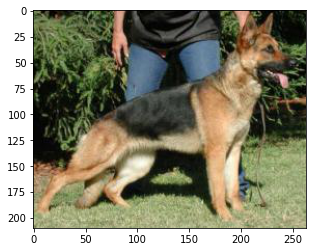

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('/content/data/Images/n02106662-German_shepherd/n02106662_11808.jpg')

imgplot = plt.imshow(img)

In [ ]:

# tengo el planteamiento que se puede usar esta clase para poder hacer el tratamiento del dataset 
from PIL import Image
from os.path import join
import os
import scipy.io
import collections
import torch.utils.data as data
from torchvision.datasets.utils import download_url, list_dir, list_files
from xml.etree.ElementTree import Element as ET_Element
try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse


class BreedsDogs(data.Dataset):
    """`Stanford Dogs <http://vision.stanford.edu/aditya86/ImageNetDogs/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``omniglot-py`` exists.
        cropped (bool, optional): If true, the images will be cropped into the bounding box specified
            in the annotations
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset tar files from the internet and
            puts it in root directory. If the tar files are already downloaded, they are not
            downloaded again.
    """
    folder = 'data'
    download_url_prefix = 'http://vision.stanford.edu/aditya86/ImageNetDogs'

    def __init__(self,
                 root,
                 train=True,
                 transforms=None,
                 download=False):

        self.root = join(os.path.expanduser(root), self.folder)
        # print(f"directorio raiz: {self.root}")

        self.train = train
        self.transforms = transforms
        if download:
            self.download()

        self.split = self.load_split()
        # print("Anotaciones")
        # print(self.split)

        self.images_folder = join(self.root, 'Images')
        # print(f"directorio de imagenes: {self.images_folder}")
        self.annotations_folder = join(self.root, 'Annotation')
        # print(f"directorio de anotaciones: {self.annotations_folder}")

        self._breeds = list_dir(self.images_folder)
        # print("Tipos de perros:")
        # print(self._breeds)

        self._breed_images = [(annotation+'.jpg', idx) for annotation, idx in self.split]

        # print("Imagenes por raza:")
        # print(self._breed_images[:5])
        # self.classes = ["Chihuaha",
        #                 "Japanese Spaniel",
        #                 "Maltese Dog",
        #                 "Pekinese",
        #                 "Shih-Tzu",
        #                 "Blenheim Spaniel",
        #                 "Papillon",
        #                 "Toy Terrier",
        #                 "Rhodesian Ridgeback",
        #                 "Afghan Hound",
        #                 "Basset Hound",
        #                 "Beagle",
        #                 "Bloodhound",
        #                 "Bluetick",
        #                 "Black-and-tan Coonhound",
        #                 "Walker Hound",
        #                 "English Foxhound",
        #                 "Redbone",
        #                 "Borzoi",
        #                 "Irish Wolfhound",
        #                 "Italian Greyhound",
        #                 "Whippet",
        #                 "Ibizian Hound",
        #                 "Norwegian Elkhound",
        #                 "Otterhound",
        #                 "Saluki",
        #                 "Scottish Deerhound",
        #                 "Weimaraner",
        #                 "Staffordshire Bullterrier",
        #                 "American Staffordshire Terrier",
        #                 "Bedlington Terrier",
        #                 "Border Terrier",
        #                 "Kerry Blue Terrier",
        #                 "Irish Terrier",
        #                 "Norfolk Terrier",
        #                 "Norwich Terrier",
        #                 "Yorkshire Terrier",
        #                 "Wirehaired Fox Terrier",
        #                 "Lakeland Terrier",
        #                 "Sealyham Terrier",
        #                 "Airedale",
        #                 "Cairn",
        #                 "Australian Terrier",
        #                 "Dandi Dinmont",
        #                 "Boston Bull",
        #                 "Miniature Schnauzer",
        #                 "Giant Schnauzer",
        #                 "Standard Schnauzer",
        #                 "Scotch Terrier",
        #                 "Tibetan Terrier",
        #                 "Silky Terrier",
        #                 "Soft-coated Wheaten Terrier",
        #                 "West Highland White Terrier",
        #                 "Lhasa",
        #                 "Flat-coated Retriever",
        #                 "Curly-coater Retriever",
        #                 "Golden Retriever",
        #                 "Labrador Retriever",
        #                 "Chesapeake Bay Retriever",
        #                 "German Short-haired Pointer",
        #                 "Vizsla",
        #                 "English Setter",
        #                 "Irish Setter",
        #                 "Gordon Setter",
        #                 "Brittany",
        #                 "Clumber",
        #                 "English Springer Spaniel",
        #                 "Welsh Springer Spaniel",
        #                 "Cocker Spaniel",
        #                 "Sussex Spaniel",
        #                 "Irish Water Spaniel",
        #                 "Kuvasz",
        #                 "Schipperke",
        #                 "Groenendael",
        #                 "Malinois",
        #                 "Briard",
        #                 "Kelpie",
        #                 "Komondor",
        #                 "Old English Sheepdog",
        #                 "Shetland Sheepdog",
        #                 "Collie",
        #                 "Border Collie",
        #                 "Bouvier des Flandres",
        #                 "Rottweiler",
        #                 "German Shepard",
        #                 "Doberman",
        #                 "Miniature Pinscher",
        #                 "Greater Swiss Mountain Dog",
        #                 "Bernese Mountain Dog",
        #                 "Appenzeller",
        #                 "EntleBucher",
        #                 "Boxer",
        #                 "Bull Mastiff",
        #                 "Tibetan Mastiff",
        #                 "French Bulldog",
        #                 "Great Dane",
        #                 "Saint Bernard",
        #                 "Eskimo Dog",
        #                 "Malamute",
        #                 "Siberian Husky",
        #                 "Affenpinscher",
        #                 "Basenji",
        #                 "Pug",
        #                 "Leonberg",
        #                 "Newfoundland",
        #                 "Great Pyrenees",
        #                 "Samoyed",
        #                 "Pomeranian",
        #                 "Chow",
        #                 "Keeshond",
        #                 "Brabancon Griffon",
        #                 "Pembroke",
        #                 "Cardigan",
        #                 "Toy Poodle",
        #                 "Miniature Poodle",
        #                 "Standard Poodle",
        #                 "Mexican Hairless",
        #                 "Dingo",
        #                 "Dhole",
        #                 "African Hunting Dog"]

    def __len__(self):
        return len(self._breed_images)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target). target are the properties as annotations in image
        """
        image_name, target_class = self._breed_images[index]
        image_path = join(self.images_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        target = self.parse_voc_xml(ET_parse(self.annotations_folder + '/' + self.split[index][0]).getroot())

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def parse_voc_xml(self, node: ET_Element):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

    def download(self):
        import tarfile

        if os.path.exists(join(self.root, 'Images')) and os.path.exists(join(self.root, 'Annotation')):
            if len(os.listdir(join(self.root, 'Images'))) == len(os.listdir(join(self.root, 'Annotation'))) == 120:
                print('Files already downloaded and verified')
                return

        for filename in ['images', 'annotation', 'lists']:
            tar_filename = filename + '.tar'
            url = self.download_url_prefix + '/' + tar_filename
            download_url(url, self.root, tar_filename, None)
            print('Extracting downloaded file: ' + join(self.root, tar_filename))
            with tarfile.open(join(self.root, tar_filename), 'r') as tar_file:
                tar_file.extractall(self.root)
            os.remove(join(self.root, tar_filename))

    def load_split(self):
        if self.train:
            # print(f"directorio lista de entrenamiento: {self.root}")
            split = scipy.io.loadmat(join(self.root, 'train_list.mat'))['annotation_list']
            # print(split)
            labels = scipy.io.loadmat(join(self.root, 'train_list.mat'))['labels']
            # print(labels)
        else:
            split = scipy.io.loadmat(join(self.root, 'test_list.mat'))['annotation_list']
            labels = scipy.io.loadmat(join(self.root, 'test_list.mat'))['labels']

        split = [item[0][0] for item in split]
        labels = [item[0]-1 for item in labels]
        return list(zip(split, labels))

    def stats(self):
        counts = {}
        for index in range(len(self._breed_images)):
            image_name, target_class = self._breed_images[index]
            if target_class not in counts.keys():
                counts[target_class] = 1
            else:
                counts[target_class] += 1

        print(f"{ len(self._breed_images)} samples spanning { len(counts.keys()) }  classes (avg { float(len(self._breed_images)) / float(len(counts.keys())) } % per class")

        return counts


In [ ]:
breeds_dogs_train_dataset = BreedsDogs('/content')
breeds_dogs_test_dataset = BreedsDogs('/content', train=False)
# classes = breeds_dogs_train_dataset.classes

print(breeds_dogs_train_dataset[0])

(<PIL.Image.Image image mode=RGB size=360x300 at 0x7F41A8208650>, {'annotation': {'folder': '02085620', 'filename': 'n02085620_5927', 'source': {'database': 'ImageNet database'}, 'size': {'width': '360', 'height': '300', 'depth': '3'}, 'segment': '0', 'object': [{'name': 'Chihuahua', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '30', 'ymin': '14', 'xmax': '236', 'ymax': '298'}}]}})


In [ ]:
classes_breed_dogs = []

for eds in breeds_dogs_train_dataset:
  img, label = eds
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  for ann in anns:
    if ann['name'] not in classes_breed_dogs:
        classes_breed_dogs.append(str(ann['name'])) 

print(classes_breed_dogs)


['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = breeds_dogs_train_dataset[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
 
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([voc_classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, classes=voc_classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

In [ ]:
import os 
PATH = '/content/data/Images'
classes = os.listdir(PATH)
print(len(classes))

imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

print(imgs)
print(labels)

120
Categoría: n02086240-Shih-Tzu. Imágenes: 214
Categoría: n02093991-Irish_terrier. Imágenes: 169
Categoría: n02096177-cairn. Imágenes: 197
Categoría: n02106030-collie. Imágenes: 153
Categoría: n02111889-Samoyed. Imágenes: 218
Categoría: n02111129-Leonberg. Imágenes: 210
Categoría: n02113186-Cardigan. Imágenes: 155
Categoría: n02106166-Border_collie. Imágenes: 150
Categoría: n02086646-Blenheim_spaniel. Imágenes: 188
Categoría: n02113799-standard_poodle. Imágenes: 159
Categoría: n02088364-beagle. Imágenes: 195
Categoría: n02107312-miniature_pinscher. Imágenes: 184
Categoría: n02090379-redbone. Imágenes: 148
Categoría: n02113712-miniature_poodle. Imágenes: 155
Categoría: n02088632-bluetick. Imágenes: 171
Categoría: n02102040-English_springer. Imágenes: 159
Categoría: n02095570-Lakeland_terrier. Imágenes: 197
Categoría: n02106662-German_shepherd. Imágenes: 152
Categoría: n02091244-Ibizan_hound. Imágenes: 188
Categoría: n02111277-Newfoundland. Imágenes: 195
Categoría: n02099712-Labrador_r

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(16464, 4116)

In [ ]:
import torch


class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [ ]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(16464, 4116)

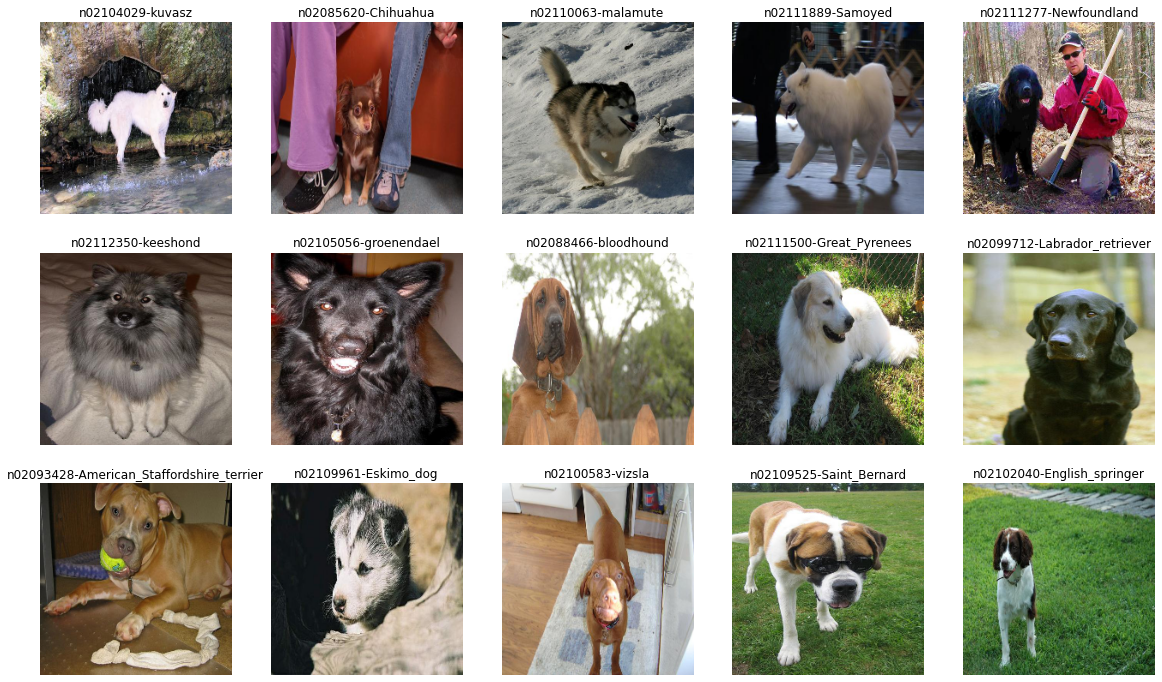

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10*2,6*2))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
print(imgs.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 120)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [ ]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 120])

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = Model()
fit(model, dataloader, epochs=15)




  0%|          | 0/258 [00:00<?, ?it/s]


loss 4.80063 acc 0.00000:   0%|          | 0/258 [00:00<?, ?it/s]


loss 4.80063 acc 0.00000:   0%|          | 1/258 [00:00<03:22,  1.27it/s]


loss 4.85005 acc 0.00000:   0%|          | 1/258 [00:01<03:22,  1.27it/s]


loss 4.85005 acc 0.00000:   1%|          | 2/258 [00:01<03:17,  1.30it/s]


loss 4.87847 acc 0.00521:   1%|          | 2/258 [00:02<03:17,  1.30it/s]


loss 4.87847 acc 0.00521:   1%|          | 3/258 [00:02<03:19,  1.28it/s]


loss 4.87888 acc 0.01172:   1%|          | 3/258 [00:03<03:19,  1.28it/s]


loss 4.87888 acc 0.01172:   2%|▏         | 4/258 [00:03<03:13,  1.32it/s]


loss 4.86655 acc 0.01250:   2%|▏         | 4/258 [00:03<03:13,  1.32it/s]


loss 4.86655 acc 0.01250:   2%|▏         | 5/258 [00:03<03:09,  1.34it/s]


loss 4.84577 acc 0.01823:   2%|▏         | 5/258 [00:04<03:09,  1.34it/s]


loss 4.84577 acc 0.01823:   2%|▏         | 6/258 [00:04<03:06,  1.35it/s]


loss 4.85526 acc 0.01562:   2%|▏         | 6/258 [0

RuntimeError: ignored

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0/258 [00:00<?, ?it/s]



loss 5.19562 acc 0.00000:   0%|          | 0/258 [00:00<?, ?it/s]



loss 5.19562 acc 0.00000:   0%|          | 1/258 [00:00<02:21,  1.81it/s]



loss 5.15301 acc 0.00000:   0%|          | 1/258 [00:01<02:21,  1.81it/s]



loss 5.15301 acc 0.00000:   1%|          | 2/258 [00:01<02:29,  1.71it/s]



loss 5.16307 acc 0.00521:   1%|          | 2/258 [00:01<02:29,  1.71it/s]



loss 5.16307 acc 0.00521:   1%|          | 3/258 [00:01<02:21,  1.80it/s]



loss 5.14079 acc 0.00391:   1%|          | 3/258 [00:02<02:21,  1.80it/s]



loss 5.14079 acc 0.00391:   2%|▏         | 4/258 [00:02<02:17,  1.85it/s]



loss 5.09090 acc 0.00937:   2%|▏         | 4/258 [00:02<02:17,  1.85it/s]



loss 5.09090 acc 0.00937:   2%|▏         | 5/258 [00:02<02:12,  1.91it/s]



loss 5.06928 acc 0.00781:   2%|▏         | 5/258 [00:03<02:12,  1.91it/s]



loss 5.06928 acc 0.00781:   2%|▏         | 6/258 [00:03<02:10,  1.92it/s]



loss 5.05658 acc 0.00670:   2%|▏         

RuntimeError: ignored

In [ ]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)






  0%|          | 0/258 [00:00<?, ?it/s]




loss 4.98504 acc 0.01562:   0%|          | 0/258 [00:01<?, ?it/s]




loss 4.98504 acc 0.01562:   0%|          | 1/258 [00:01<04:26,  1.04s/it]




loss 4.95522 acc 0.00781:   0%|          | 1/258 [00:01<04:26,  1.04s/it]




loss 4.95522 acc 0.00781:   1%|          | 2/258 [00:01<04:13,  1.01it/s]




loss 4.92238 acc 0.01042:   1%|          | 2/258 [00:02<04:13,  1.01it/s]




loss 4.92238 acc 0.01042:   1%|          | 3/258 [00:02<03:59,  1.06it/s]




loss 4.92464 acc 0.01172:   1%|          | 3/258 [00:03<03:59,  1.06it/s]




loss 4.92464 acc 0.01172:   2%|▏         | 4/258 [00:03<03:54,  1.09it/s]




loss 4.93403 acc 0.00937:   2%|▏         | 4/258 [00:04<03:54,  1.09it/s]




loss 4.93403 acc 0.00937:   2%|▏         | 5/258 [00:04<03:36,  1.17it/s]




loss 4.94294 acc 0.00781:   2%|▏         | 5/258 [00:05<03:36,  1.17it/s]




loss 4.94294 acc 0.00781:   2%|▏         | 6/258 [00:05<03:29,  1.21it/s]




loss 4.94494 acc 0.0067

RuntimeError: ignored

In [ ]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)







  0%|          | 0/258 [00:00<?, ?it/s]





loss 4.91933 acc 0.01562:   0%|          | 0/258 [00:00<?, ?it/s]





loss 4.91933 acc 0.01562:   0%|          | 1/258 [00:00<03:15,  1.32it/s]





loss 4.96990 acc 0.00781:   0%|          | 1/258 [00:01<03:15,  1.32it/s]





loss 4.96990 acc 0.00781:   1%|          | 2/258 [00:01<03:04,  1.39it/s]





loss 4.98996 acc 0.00521:   1%|          | 2/258 [00:02<03:04,  1.39it/s]





loss 4.98996 acc 0.00521:   1%|          | 3/258 [00:02<02:57,  1.44it/s]





loss 4.96512 acc 0.00781:   1%|          | 3/258 [00:02<02:57,  1.44it/s]





loss 4.96512 acc 0.00781:   2%|▏         | 4/258 [00:02<02:55,  1.45it/s]





loss 4.99965 acc 0.00937:   2%|▏         | 4/258 [00:03<02:55,  1.45it/s]





loss 4.99965 acc 0.00937:   2%|▏         | 5/258 [00:03<02:49,  1.49it/s]





loss 4.98646 acc 0.00781:   2%|▏         | 5/258 [00:03<02:49,  1.49it/s]





loss 4.98646 acc 0.00781:   2%|▏         | 6/258 [00:03<02:46,  1.52it/s]





loss 4.97

RuntimeError: ignored

In [ ]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])